# Project: Geospatial Analysis of Policies and Mental Health in Sexual Minority Youth

Author: Amanpreet Bhogal

---

The following project will examine the relationship between harmful/protective LGBTQIA+ policies by state, and their impact on sexual minority youth mental health outcomes. Specifically, we are interested in examining sexual minority youth suicidal ideation. 

## Motivation

The prevalence of diagnosed mental or behavioral health conditions has increased by 36 percent between the years 2016 and 2023 (Sappenfield et al., 2024), highlighting the need to examine risk factors for poor youth mental health. Prior work by Price and Mulkern (2025) emphasized the relation of sociopolitical climate as central to understanding health trajectories for stigmatized populations (e.g., LGBTQ+ youth). Data from the Adolescent Brain and Cognitive Development study found that cisgender LGBTQ+ youth living in areas with higher (vs. lower) levels of structural homophobia experience more mental health problems. Building upon prior findings that highlight spatial disparities in youth mental health, this project will examine the relationship between state-level LGBTQIA+ policies and suicidal ideation among sexual minority youth. By linking policy indices (harmful/protective laws) to mental health outcomes, this analysis aims to identify geographic patterns of risk, informing policy interventions and public health strategies.



## Research Questions
1. **Are sexual minority youth at higher risk for suicidal ideation than heterosexual youth?**
2. **How do state-level policy environments and geographic location influence suicidal ideation among sexual minority youth?**

## Data Sources

Census Bureau TIGER/Line Shapefiles: https://www2.census.gov/geo/tiger/GENZ2022/shp/

Youth Risk Behavior Surveillance System (YRBSS): https://www.cdc.gov/yrbs/data/index.html

LGBTQ+ Policy Data: https://www.icpsr.umich.edu/web/RCMD/studies/37877


The Census Bureau TIGER/Line shapefiles are map files that contain geometric boundaries of geographic entities, such as, U.S. states. Each shapefile has an attribute table with one row per geographic feature (e.g., per state). These attributes are our key identifiers to join external data (e.g., YRBSS and LGBTQ+ policy data) to the shapefile. The CDC's Youth Risk Behavior Surveillance System data contains information regarding youth sexual identity, mental health status, and state-level geographic location. The data is broken up into smaller files by states. All YRBSS files will be merged to create a national sample. The LGBTQ+ policy data contains policy tallies for each state where lower numbers reflect more harmful policies and higher numbers reflect protective policies for LGBTQ+ individuals. By utilizing the shapefile, we can link data on LGBTQ+ youth mental health and policies at each state's geographic location. This will be done by using the "name" variable in the shapefile, and state names from the YRBSS data and policy data. 

In [1]:
# Load in pacakages necessary for data cleaning and analysis
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import chi2_contingency, chi2
from statsmodels.tools.sm_exceptions import PerfectSeparationError

In [3]:
# Import shapefiles
shp_path = Path("cb_2022_us_state_20m/cb_2022_us_state_20m.shp")
gdf = gpd.read_file(shp_path).to_crs(4326)

In [4]:
# Inspect shapefile data
gdf.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,48,01779801,0400000US48,48,TX,Texas,00,676685555821,18974391187,"POLYGON ((-106.62344 31.91403, -106.63011 31.9..."
1,06,01779778,0400000US06,06,CA,California,00,403673617862,20291712025,"MULTIPOLYGON (((-118.59397 33.4672, -118.48478..."
2,21,01779786,0400000US21,21,KY,Kentucky,00,102266581101,2384240769,"POLYGON ((-89.54443 36.57451, -89.47935 36.566..."
3,13,01705317,0400000US13,13,GA,Georgia,00,149486268417,4418716153,"POLYGON ((-85.60516 34.98468, -85.47434 34.983..."
4,55,01779806,0400000US55,55,WI,Wisconsin,00,140292518676,29343193162,"MULTIPOLYGON (((-86.93428 45.42115, -86.83575 ..."


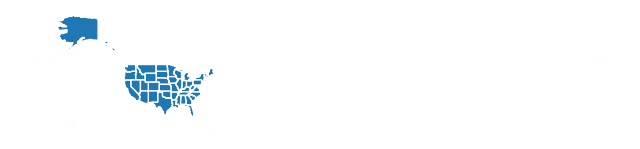

In [5]:
# Visualize shape data to ensure the shapefile imported correctly
ax = gdf.plot(edgecolor="white", figsize=(8,5))
ax.set_axis_off()

In [7]:
# Import YRBSS data from directory

"""
DESC: Load all CSV files from a directory into individual variables

PARAMS:
    my_path: str - The path to the directory containing the CSV files

RETURNS:
    tuple - A tuple containing the DataFrames for each CSV file
"""
def load_data_from_dir(my_path):
    """Load all CSV files from a directory into individual variables."""

    # Create an empty list to store the the data frames
    dataframes = []

    # Use list comprehension to get the filenames of all the CSVs in the directory
    filenames = sorted([f for f in os.listdir(my_path) if f.endswith('.csv')])

    # Loop through the filenames and read each CSV into a DataFrame
    for filename in filenames:
        df = pd.read_csv(os.path.join(my_path, filename))
        dataframes.append(df)

    # Return the dataframes as a tuple
    return tuple(dataframes)


# Load the data
# variable assignment known as tuple unpacking
sadc_2023_state_ad, sadc_2023_state_eh, sadc_2023_state_il, sadc_2023_state_mbis, sadc_2023_state_np, sadc_2023_state_qt, sadc_2023_state_uz = \
    load_data_from_dir("HS_data")

# You may need to change the my_path argument to the directory where your CSV files are located ^^^

In [11]:
# Import policy data
proj = Path.cwd()
policy = pd.read_csv(proj / "policy_2020_data.csv")
policy.head()

,V001,V002,V003,V004,V005,V006,V007,V008,V009,V010,...,V089,V090,V091,V092,V093,V094,V095,V096,V003_midpoint,V005_midpoint
0,Alabama,-6.50,(1) Negative: Less than zero,-2.00,(1) Negative: Less than zero,-4.50,(1) Negative: Less than zero,1.50,0.0,-5.0,...,0.0,0.00,(0) If state does not prohibit use of 'trans p...,0.0,-1.00,0.0,-1.0,(1) Does not require public announcement of na...,-1.00,-1.00
1,Alaska,3.75,(2) Low: 0-24.9% of total possible points,2.50,(2) Low: 0-24.9% of total possible sexual orie...,1.25,(2) Low: 0-24.9% of total possible gender iden...,1.50,2.0,0.0,...,0.0,-0.25,(0) If state does not prohibit use of 'trans p...,0.0,0.75,0.0,1.0,(0) Requirement of public announcement of name...,12.45,12.45
2,Arizona,3.75,(2) Low: 0-24.9% of total possible points,5.25,(3) Fair: 25-49.9% of total,-1.50,(1) Negative: Less than zero,2.50,2.0,-1.0,...,0.0,0.00,(0) If state does not prohibit use of 'trans p...,0.0,0.25,0.0,-1.0,(0) Requirement of public announcement of name...,12.45,37.45
3,Arkansas,0.50,(2) Low: 0-24.9% of total possible points,1.00,(2) Low: 0-24.9% of total possible sexual orie...,-0.50,(1) Negative: Less than zero,2.00,-2.0,-1.0,...,0.0,-1.00,(0) If state does not prohibit use of 'trans p...,0.5,1.00,0.0,-1.0,(1) Does not require public announcement of na...,12.45,12.45
4,California,34.75,(5) High: 75-100% of total,16.50,(5) High: 75-100% of total,18.25,(5) High: 75-100% of total,6.25,7.0,0.0,...,1.0,-0.25,(1) If state prohibits use of defense,0.5,1.00,0.5,1.0,(1) Does not require public announcement of na...,87.50,87.50


## Data Description 

1. Shapefile - For the shapefile data, we will be utilizing 'NAME' since we have names of each of the states in all of our datasets. 
2. Policy data - For the policy data, we will subset it to only include the state name and the sexual orientation policy tally since our analyses are focused on sexual minority youth. 
3. YRBS data - For the YRBS data, we will subset the data so that it includes data from 2015 onwards. This is because data was not collected on sexual identity prior to 2015. Further, we will subset the data to include state name, age, sex, sexual identity, and our outcome variable that collects whether youth endorsed saying yes or no to whether youth considered suicide.  

In [12]:
# View the shape of each dataframe
dataframes = [sadc_2023_state_ad, sadc_2023_state_eh, sadc_2023_state_il, sadc_2023_state_mbis, sadc_2023_state_np, sadc_2023_state_qt, sadc_2023_state_uz]

for i, df in enumerate(dataframes):
    print(f"csv{i}: {df.shape}")

csv0: (105455, 269)
csv1: (126244, 269)
csv2: (127796, 269)
csv3: (482864, 269)
csv4: (332732, 269)
csv5: (98021, 269)
csv6: (280797, 269)


In [13]:
# Combine all YRBSS dataframes into one
combined_df = pd.concat([dataframes[0], dataframes[1], dataframes[2], dataframes[3], dataframes[4], dataframes[5], dataframes[6]])

In [14]:
# Create a copy of the combined dataframe
df = combined_df.copy()

# Treat both real NaN and the literal string "Missing" as missing
is_missing = df["sexid2"].isna() | df["sexid2"].eq("Missing")

# Calculate total and missing counts by year
by_year = (
    df.assign(is_missing=is_missing)
      .groupby("year", as_index=False)
      .agg(total=("sexid2", "size"), missing=("is_missing", "sum"))
      .assign(pct_missing=lambda d: 100 * d["missing"] / d["total"])
      .sort_values("year")
)

by_year

,year,total,missing,pct_missing
0,1991,28376,28376,100.000000
1,1993,58975,58975,100.000000
2,1995,48443,48443,100.000000
3,1997,44048,44048,100.000000
4,1999,39454,39454,100.000000
5,2001,51240,51240,100.000000
6,2003,56927,56927,100.000000
7,2005,81186,81186,100.000000
8,2007,80672,80672,100.000000
9,2009,89124,89124,100.000000


There is no data on sexual identity until 2021. We are going to subset the data to only include data from the years 2021 and 2023 since sexual identity is a key variable in our study. 

In [15]:
# There is no data on sexual identity until 2021. We are going to subset the data to only include data from the years 2021 and 2023.
combined_df = combined_df[combined_df["year"] > 2019]

In [16]:
# Filter to variables of interest
filtered = combined_df[["sitecode", "year", "age", "sex", "race7", "sexid2", "q27"]]
filtered

,sitecode,year,age,sex,race7,sexid2,q27
99391,Alabama,2021,12 years old or younger,Missing,Missing,Missing,Yes
99392,Alabama,2021,14 years old,Missing,Missing,Missing,Missing
99393,Alabama,2021,14 years old,Missing,Hispanic/Latino,Missing,Missing
99394,Alabama,2021,15 years old,Missing,Missing,Missing,Missing
99395,Alabama,2021,17 years old,Missing,Missing,Missing,Missing
...,...,...,...,...,...,...,...
280792,Wisconsin,2023,18 years old or older,Female,White,Heterosexual,No
280793,Wisconsin,2023,18 years old or older,Female,White,Heterosexual,No
280794,Wisconsin,2023,18 years old or older,Female,White,Heterosexual,No
280795,Wisconsin,2023,18 years old or older,Female,White,Other/Questioning,No


In [17]:
# View column names of filtered dataframe
filtered.columns

Index(['sitecode', 'year', 'age', 'sex', 'race7', 'sexid2', 'q27'], dtype='object')

In [18]:
# View number of missing values in each column of filtered dataframe
filtered.isna().sum()

sitecode    0
year        0
age         0
sex         0
race7       0
sexid2      0
q27         0
dtype: int64

In [19]:
# View the number of missing values in each column
policy.isna().sum()

V001             0
V002             0
V003             0
V004             0
V005             0
                ..
V094             0
V095             0
V096             0
V003_midpoint    0
V005_midpoint    0
Length: 98, dtype: int64

In [41]:
# Enter the midpoint of the data for analyses 
policy['V005_MP'] = policy['V005'].apply(lambda x: -1 if x == '(1) Negative: Less than zero'
else 12.45 if x == '(2) Low: 0-24.9% of total possible sexual orientation points'
else 37.45 if x == '(3) Fair: 25-49.9% of total'
else 62.45 if x == '(4) Medium: 50-74.9% of total'
else 87.5
)

In [42]:
# Rename columns in policy data for merging
policy_filtered = policy.rename(columns={'V001': 'NAME', 'V005_MP': 'Sexual_Orientation_Policy_Tally'})

In [43]:
# Subset policy data to only include variables of interest
policy_filtered = policy_filtered[['NAME', 'Sexual_Orientation_Policy_Tally']]
policy_filtered

,NAME,Sexual_Orientation_Policy_Tally
0,Alabama,-1.00
1,Alaska,12.45
2,Arizona,37.45
3,Arkansas,12.45
4,California,87.50
5,Colorado,87.50
6,Connecticut,87.50
7,Delaware,62.45
8,District of Columbia,87.50
9,Florida,12.45


## Data Manipulation

Ensure the state names are spelled correctly in each dataframe.


In [20]:
# Check to make sure the state names are spelled correctly
filtered['sitecode'].unique()

array(['Alabama', 'Arkansas', 'Arizona', 'Colorado', 'Alaska', 'Florida',
       'Georgia', 'Hawaii', 'Iowa', 'Idaho', 'Illinois', 'Indiana',
       'Kansas', 'Kentucky', 'Maryland', 'Michigan', 'Missouri',
       'Mississippi', 'Montana', 'Massachusetts', 'North Carolina',
       'North Dakota', 'Nebraska', 'New Hampshire', 'New Jersey',
       'New Mexico', 'Nevada', 'New York (Excluding NYC)', 'Oklahoma',
       'Pennsylvania', 'South Carolina', 'Tennessee', 'Texas', 'Utah',
       'Virginia', 'Vermont', 'Wisconsin'], dtype=object)

New York has been written as "New York (Excluding NYC)" which will not match with the shapefile. We will have to rename this response to be New York.

In [21]:
# Replace "New York (Excluding NYC)" with "New York"
filtered['sitecode'] = filtered['sitecode'].replace("New York (Excluding NYC)", "New York")

/var/folders/8l/vgml2k35387dhk61l9sf8c8m0000gn/T/ipykernel_41065/770213885.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['sitecode'] = filtered['sitecode'].replace("New York (Excluding NYC)", "New York")


In [22]:
# Check again to make sure the state names are spelled correctly
filtered['sitecode'].unique()

array(['Alabama', 'Arkansas', 'Arizona', 'Colorado', 'Alaska', 'Florida',
       'Georgia', 'Hawaii', 'Iowa', 'Idaho', 'Illinois', 'Indiana',
       'Kansas', 'Kentucky', 'Maryland', 'Michigan', 'Missouri',
       'Mississippi', 'Montana', 'Massachusetts', 'North Carolina',
       'North Dakota', 'Nebraska', 'New Hampshire', 'New Jersey',
       'New Mexico', 'Nevada', 'New York', 'Oklahoma', 'Pennsylvania',
       'South Carolina', 'Tennessee', 'Texas', 'Utah', 'Virginia',
       'Vermont', 'Wisconsin'], dtype=object)

In [23]:
# Create a copy of the filtered dataframe
copy = filtered
# Replace "Missing" with NaN
copy.replace("Missing", np.nan, inplace=True)
# Reset index
copy = copy.reset_index()
# View the first few rows of the cleaned dataframe
copy.head()

/var/folders/8l/vgml2k35387dhk61l9sf8c8m0000gn/T/ipykernel_41065/1305238816.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy.replace("Missing", np.nan, inplace=True)


,index,sitecode,year,age,sex,race7,sexid2,q27
0,99391,Alabama,2021,12 years old or younger,NaN,NaN,NaN,Yes
1,99392,Alabama,2021,14 years old,NaN,NaN,NaN,NaN
2,99393,Alabama,2021,14 years old,NaN,Hispanic/Latino,NaN,NaN
3,99394,Alabama,2021,15 years old,NaN,NaN,NaN,NaN
4,99395,Alabama,2021,17 years old,NaN,NaN,NaN,NaN


I created a copy of our data and reset the index for a clean copy of our dataframe that we could further manipulate. 

## Data Visualization
1. Create histogram for sex
2. Create histogram for age categories
3. Create histogram for sexual identity to see breakdown of different sexual orientation identities in our dataframe. 
3. Create unstacked bar chart for age categories to see suicidal ideation

/var/folders/8l/vgml2k35387dhk61l9sf8c8m0000gn/T/ipykernel_41065/1538083812.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


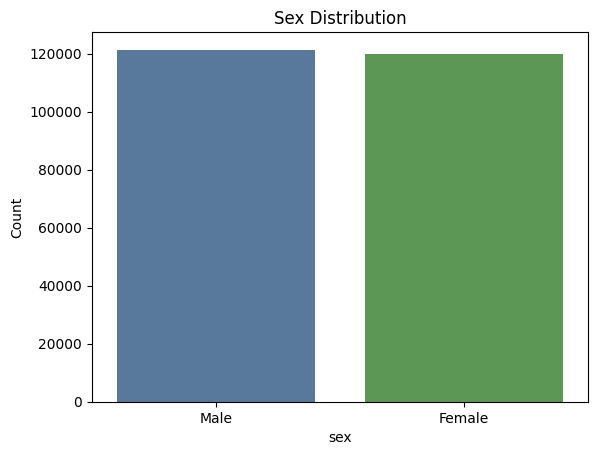

In [38]:
# Create a histogram to visualize the distribution of sex
ax = sns.countplot(
    data=copy, x="sex",                
    palette={"Male":"#4C78A8", "Female":"#54A24B"}  
)
ax.set_title("Sex Distribution")
ax.set_xlabel("sex"); ax.set_ylabel("Count")
plt.show()

### Histogram Interpretation

The histogram shows that the dataset includes nearly equal numbers of male and female participants, indicating a balanced sex distribution. This balance helps ensure that any analyses comparing groups are not biased by unequal representation.

/var/folders/8l/vgml2k35387dhk61l9sf8c8m0000gn/T/ipykernel_41065/3257947235.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


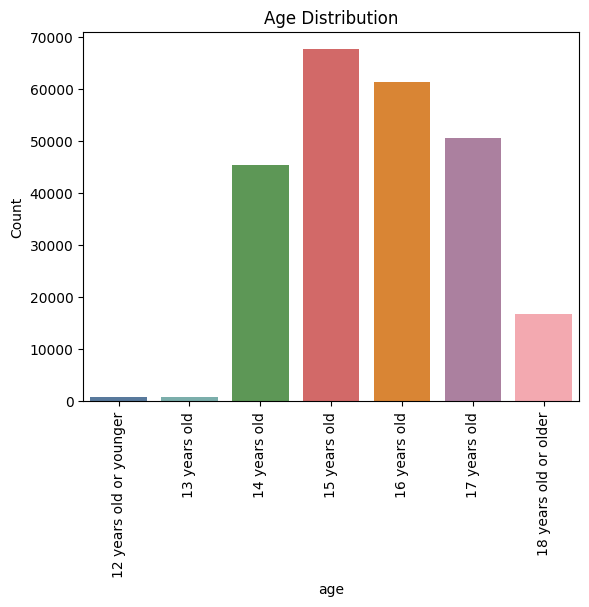

In [36]:
# Create a histogram to visualize the distribution of age
# Pick the order of ages for the x-axis:
age_order = ["12 years old or younger","13 years old","14 years old","15 years old",
             "16 years old","17 years old","18 years old or older"]

age_colors = ["#4C78A8","#72B7B2","#54A24B","#E45756","#F58518","#B279A2","#FF9DA6"]
age_palette = dict(zip(age_order, age_colors))

ax = sns.countplot(
    data=copy, x="age",
    order=age_order,
    palette=age_palette
)
ax.set_title("Age Distribution")
ax.set_xlabel("age"); ax.set_ylabel("Count")
plt.xticks(rotation=90)
plt.show()

### Histogram Interpretation

The histogram shows that most participants are between 14 and 17 years old, with noticeably fewer respondents who are 12 or younger or 18 and older. This suggests that the dataset primarily represents mid-adolescent individuals. 

/var/folders/8l/vgml2k35387dhk61l9sf8c8m0000gn/T/ipykernel_41065/3885586312.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


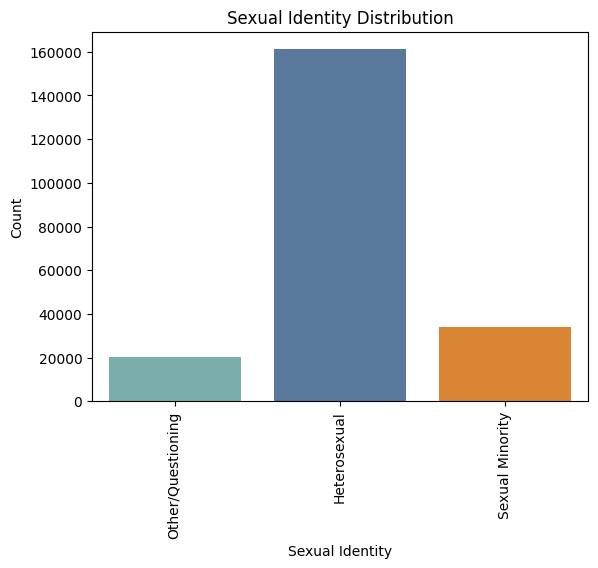

In [37]:
# Create a histogram to visualize the distribution of sexual identity
# Define custom color palette for each category
palette = {
    "Heterosexual": "#4C78A8",
    "Sexual Minority": "#F58518",
    "Other/Questioning": "#72B7B2"
}

# Plot the countplot
ax = sns.countplot(
    data=copy, x="sexid2",
    order=["Other/Questioning", "Heterosexual", "Sexual Minority"],
    palette=palette
)
ax.set_title("Sexual Identity Distribution")
ax.set_xlabel("Sexual Identity")
ax.set_ylabel("Count")
plt.xticks(rotation=90)
plt.show()

### Histogram Interpretation
The histogram shows that most participants identify as heterosexual, while a smaller proportion identify as sexual minorities or as other/questioning. This indicates that the dataset is largely composed of heterosexual respondents, with less representation from other sexual identity groups. This distribution aligns with national patterns, where sexual minority populations represent a smaller proportion of adults compared to heterosexual individuals.

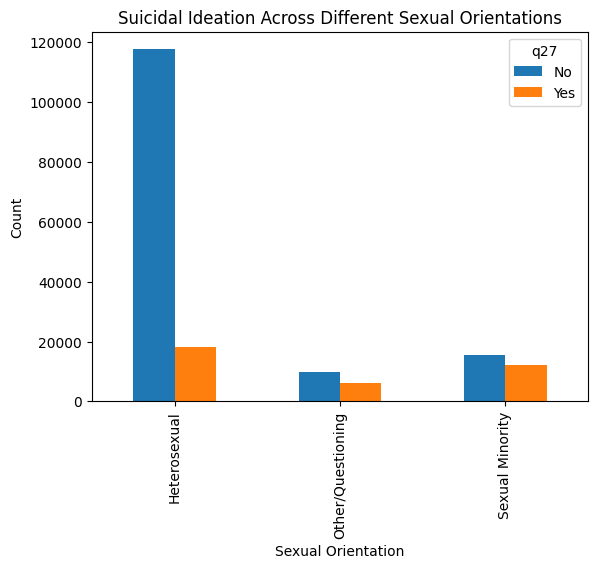

In [45]:
copy.groupby(["sexid2", "q27"]).size().unstack().plot(kind="bar")
plt.title("Suicidal Ideation Across Different Sexual Orientations")
plt.ylabel("Count")
plt.xlabel("Sexual Orientation")
plt.show()

### Interpretation
The bar chart shows that while heterosexual participants make up the largest share of the dataset, a higher proportion of sexual minority and other/questioning youth reported suicidal ideation compared to heterosexual youth.

## Logistic Regression

In [48]:

# Create copy of data
df = copy.copy()
# Create binary outcome variable
df["q27_binary"] = df["q27"].map({"Yes": 1, "No": 0})
# Drop rows with missing values in key columns
df = df.dropna(subset=["q27_binary", "sexid2", "sex", "age"])

# Ensure categorical variables are treated as such
df["sexid2"] = pd.Categorical(df["sexid2"], 
                              categories=["Heterosexual", "Sexual Minority", "Other/Questioning"])
df["sex"]    = pd.Categorical(df["sex"], categories=["Male", "Female"])
df["age"]    = pd.Categorical(df["age"], categories=[
    "12 years old or younger","13 years old","14 years old","15 years old",
    "16 years old","17 years old","18 years old or older"
])

# Fit logistic regression model for each state
results = []
for site, data in df.groupby("sitecode"):
    # skip tiny groups / degenerate outcomes
    if len(data) < 50:               # adjust threshold as you like
        continue
    if data["q27_binary"].nunique() < 2:
        continue

    try:
        model = smf.glm(
            "q27_binary ~ C(sexid2, Treatment(reference='Heterosexual'))" # Set reference category
            " + C(age, Treatment(reference='15 years old'))"
            " + C(sex, Treatment(reference='Male'))",
            data=data, family=sm.families.Binomial()
        ).fit()

        # coefficient for Sexual Minority vs Heterosexual
        key = "C(sexid2, Treatment(reference='Heterosexual'))[T.Sexual Minority]"
        coef = model.params.get(key, np.nan)
        pval = model.pvalues.get(key, np.nan)
        results.append({"sitecode": site, "estimate": coef, "p_value": pval})

    except PerfectSeparationError:
        results.append({"sitecode": site, "estimate": np.nan, "p_value": np.nan})

# Compile results into DataFrame
state_results = pd.DataFrame(results)
# Compute odds ratios to draw meaningful conclusions
state_results["odds_ratio"] = np.exp(state_results["estimate"])


The code above is to run a logistic regression since our outcome variable is a categorical variable. Additionally, we added age and sex as covariates into this model since prior work has shown that there may be sex differences in suicidal ideation. Further, adolescence is a crucial time of development where mental disorders begin to emerge. By including these covariates, we aim to isolate the association between sexual minority identity and the likelihood of considering suicide across states.

In [49]:
state_results

,sitecode,estimate,p_value,odds_ratio
0,Arizona,1.614717,8.025823e-17,5.026465
1,Arkansas,1.214505,2.742146e-12,3.368626
2,Colorado,1.487501,4.033621e-11,4.426021
3,Florida,1.458237,3.438168e-46,4.298375
4,Hawaii,1.372086,1.585840e-82,3.943570
5,Illinois,1.335077,7.310758e-52,3.800288
6,Indiana,1.591533,2.287341e-28,4.911273
7,Iowa,1.555572,6.333248e-18,4.737796
8,Kansas,1.634816,3.735869e-20,5.128514
9,Kentucky,1.421491,4.692810e-43,4.143295


These results indicate a consistent and significant association between sexual minority identity and suicidal ideation across all analyzed states. Sexual minority youth are at a substantially higher risk - typically 3 to 6 times more likely - to have seriously considered suicide compared to their heterosexual peers. Although the magnitude varies by state, the relationship remains strong everywhere, emphasizing the widespread mental health disparities faced by sexual minority adolescents.

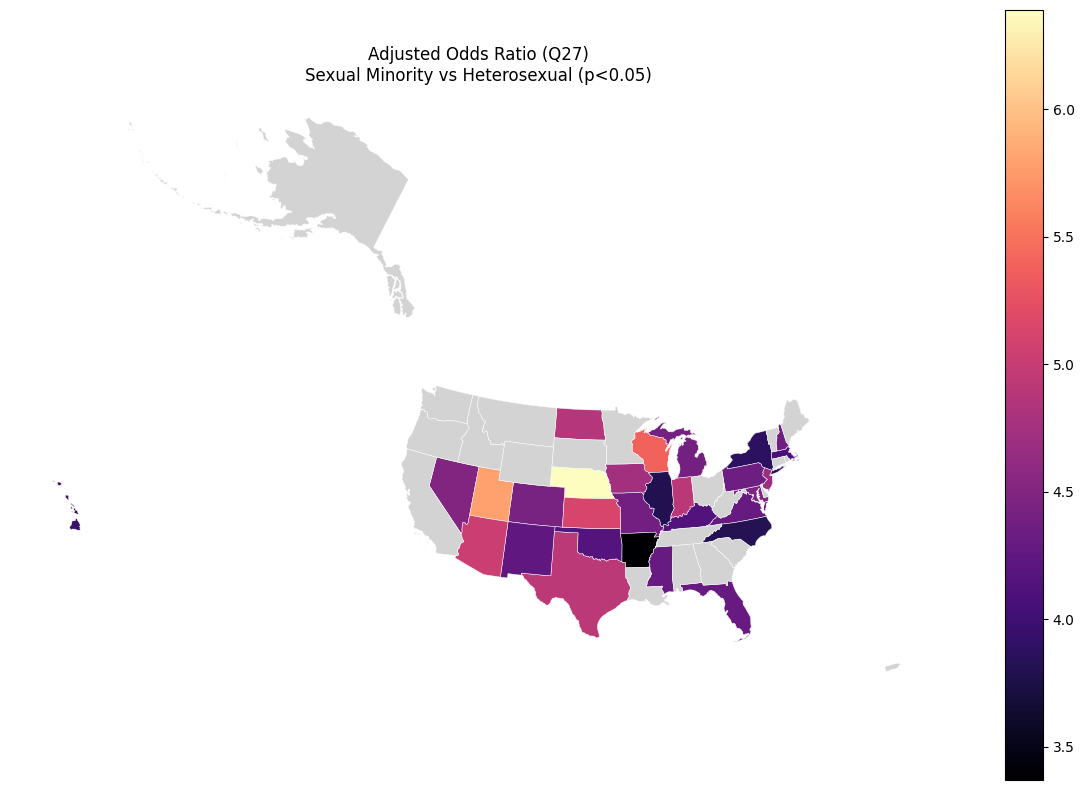

In [50]:
# Merge ORs into the geo dataframe
map_df = gdf.merge(state_results, left_on="NAME", right_on="sitecode", how="left")

# Show states with p < .05
map_df["or_sig"] = np.where(map_df["p_value"] < 0.05, map_df["odds_ratio"], np.nan)

# Project to Albers Equal Area 
map_df = map_df.to_crs(5070)

# Plot the map
ax = map_df.plot(
    column="or_sig", cmap="magma", legend=True,
    edgecolor="white", linewidth=0.35, figsize=(12,8),
    missing_kwds={"color": "lightgrey", "label": "No data"}
)
ax.set_title("Adjusted Odds Ratio (Q27)\nSexual Minority vs Heterosexual (p<0.05)")
ax.axis("off")
plt.tight_layout()
plt.savefig("choropleth_or_sig.png", dpi=300)
plt.show()

This figure displays the adjusted odds ratios of youth suicidal ideation (Q27) comparing sexual minority to heterosexual adolescents across U.S. states. Results indicate a consistent and significant disparity nationwide: sexual minority youth are between 3 to 6 times more likely to have seriously considered suicide, even after accounting for demographic factors such as age and sex. States with higher odds ratios (e.g., Nebraska, Utah, Wisconsin) may reflect regions where stigma, limited access to affirming care, or restrictive policy climates exacerbate mental health risks among LGBTQ+ youth.

In [51]:
# Add policy data to state results
state_results = state_results.merge(policy_filtered, left_on='sitecode', right_on='NAME', how='left')
state_results

,sitecode,estimate,p_value,odds_ratio,NAME,Sexual_Orientation_Policy_Tally
0,Arizona,1.614717,8.025823e-17,5.026465,Arizona,37.45
1,Arkansas,1.214505,2.742146e-12,3.368626,Arkansas,12.45
2,Colorado,1.487501,4.033621e-11,4.426021,Colorado,87.50
3,Florida,1.458237,3.438168e-46,4.298375,Florida,12.45
4,Hawaii,1.372086,1.585840e-82,3.943570,Hawaii,62.45
5,Illinois,1.335077,7.310758e-52,3.800288,Illinois,87.50
6,Indiana,1.591533,2.287341e-28,4.911273,Indiana,37.45
7,Iowa,1.555572,6.333248e-18,4.737796,Iowa,62.45
8,Kansas,1.634816,3.735869e-20,5.128514,Kansas,12.45
9,Kentucky,1.421491,4.692810e-43,4.143295,Kentucky,12.45


In [52]:
# Run a meta-analytic regression to see how policy affects the odds ratios across states
# Log-transform OR to linearize
state_results["log_or"] = np.log(state_results["odds_ratio"])

# Fit linear model
policy_model = smf.ols("log_or ~ Sexual_Orientation_Policy_Tally", data=state_results).fit()
print(policy_model.summary())

                            OLS Regression Results                            
Dep. Variable:                 log_or   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                 -0.019
Method:                 Least Squares   F-statistic:                    0.4657
Date:                Tue, 04 Nov 2025   Prob (F-statistic):              0.501
Time:                        23:10:45   Log-Likelihood:                 18.263
No. Observations:                  29   AIC:                            -32.53
Df Residuals:                      27   BIC:                            -29.79
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

This regression found no statistically significant relationship between state-level sexual orientation policy scores and the strength of the association between sexual minority status and suicidal ideation (β = -0.0006, p = 0.501). Although the direction of the effect was negative - suggesting that states with more protective LGBTQ+ policies may have slightly lower suicide risk disparities - the relationship was extremely weak and explained little of the variance (R² = 0.017).
These results suggest that policy context alone does not fully account for cross-state differences in suicidal ideation disparities between sexual minority and heterosexual youth.

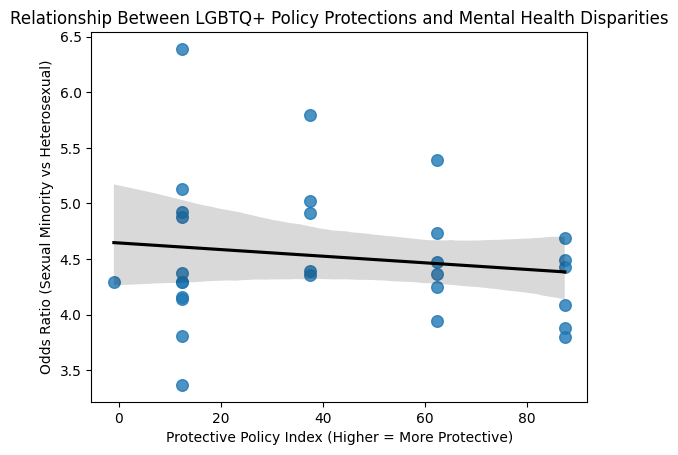

In [53]:
# Visualize the relationship between policy index and odds ratios
sns.regplot(
    x="Sexual_Orientation_Policy_Tally",
    y="odds_ratio",
    data=state_results,
    scatter_kws={"s":70},
    line_kws={"color":"black"}
)
plt.xlabel("Protective Policy Index (Higher = More Protective)")
plt.ylabel("Odds Ratio (Sexual Minority vs Heterosexual)")
plt.title("Relationship Between LGBTQ+ Policy Protections and Mental Health Disparities")
plt.show()


## Synthesis 
This project aimed to examine the relationship between state-level LGBTQIA+ policies and suicidal ideation among sexual minority youth. By linking indicators of policy protection or harm to mental health outcomes, this analysis explored how structural contexts shape disparities in youth mental health. Understanding these associations can inform more effective public health strategies and guide policy interventions aimed at reducing suicide risk among LGBTQIA+ populations.

To address this, we linked the CDC’s Youth Risk Behavior Surveillance System (YRBSS) with state-level sexual orientation policy tallies and U.S. shapefiles to analyze and visualize state-specific mental health disparities. This combined dataset was critical because it allowed us to integrate individual-level health behavior data with structural and geographic variables, enabling a more comprehensive view of how policy context and location intersect to impact mental health outcomes. The merged dataset thus provided a foundation for both statistical modeling and geospatial visualization, helping to identify where disparities are most concentrated and how they may align with differing policy climates across the U.S. Our research focused on three key questions:

1. Are sexual minority youth at higher risk for suicidal ideation than heterosexual youth?
2. Do harmful or protective LGBTQIA+ policies impact youth suicidal ideation?

The logistic regression showed a statistically significant positive association between sexual minority identity and suicidal ideation across states, with odds ratios ranging from roughly 3 to 6—indicating that sexual minority youth were several times more likely than heterosexual youth to report having seriously considered suicide.

A meta-analytic regression assessing the association between state policy tallies and odds ratios of suicidal ideation found no statistically significant relationship (β = -0.0006, p = 0.501, R² = 0.017). While the negative slope suggested that states with more protective policies may have slightly smaller disparities, the effect was minimal and not significant.

Collectively, these results suggest that although sexual minority youth face substantially elevated risks of suicidal ideation, state-level policy protections alone do not significantly explain variation in these disparities across the U.S. The persistence of high odds ratios, even in protective policy environments, indicates that broader social, familial, and institutional factors - such as stigma, gay straight alliance clubs in school, and access to affirming care - may play stronger roles in shaping mental health outcomes.

## Reflection
This project marked my first encounter with geographic information systems (GIS) and gave me the opportunity to learn about shapefiles, polygon data, and geospatial visualization. Through this experience, I was able to examine spatial patterns in sexual minority youth mental health outcomes and see how policy and geography intersect in shaping disparities. It was also my first time using Python instead of R for statistical analyses, which came with a significant learning curve as I adapted to new syntax, libraries, and workflows. One of the most challenging yet valuable aspects of the project was independently determining which statistical methods were appropriate for my research questions, which helped me grow in my ability to think critically about analytical design and interpretation.